In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline  

from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from IPython.display import display

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-11-03 16:41:20--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.11’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.002s  

2025-11-03 16:41:20 (41.1 MB/s) - ‘course_lead_scoring.csv.11’ saved [80876/80876]



In [3]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
list(df.columns)

['lead_source',
 'industry',
 'number_of_courses_viewed',
 'annual_income',
 'employment_status',
 'location',
 'interaction_count',
 'lead_score',
 'converted']

In [5]:
target = 'converted'
base_features= ['lead_source',
 'industry',
 'number_of_courses_viewed',
 'annual_income',
 'employment_status',
 'location',
 'interaction_count',
 'lead_score']

In [6]:
categorical = list(df.select_dtypes(include='object').columns)

In [7]:
numerical = list(df.select_dtypes(include='number').columns)

In [8]:
numerical.remove('converted')

In [9]:
df[categorical]=df[categorical].fillna('NA')

In [10]:
df[numerical]=df[numerical].fillna(0)

### Question 1

In [11]:
df.industry.mode()

0    retail
Name: industry, dtype: object

In [12]:
df['industry'].value_counts().sort_values(ascending=False)

industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64

### Question 2


In [13]:
df[numerical].corrwith(df.lead_score)

number_of_courses_viewed   -0.004879
annual_income               0.015610
interaction_count           0.009888
lead_score                  1.000000
dtype: float64

`interaction_count` and `lead_score` : 0.0098 

`number_of_courses_viewed` and `lead_score` : -0.0048

In [14]:
df[numerical].corrwith(df.interaction_count)

number_of_courses_viewed   -0.023565
annual_income               0.027036
interaction_count           1.000000
lead_score                  0.009888
dtype: float64

`number_of_courses_viewed` and `interaction_count` : -0.0235

`annual_income` and `interaction_count` : 0.0270

In [36]:
df[numerical].corr()


,number_of_courses_viewed,annual_income,interaction_count,lead_score
number_of_courses_viewed,1.000000,0.009770,-0.023565,-0.004879
annual_income,0.009770,1.000000,0.027036,0.015610
interaction_count,-0.023565,0.027036,1.000000,0.009888
lead_score,-0.004879,0.015610,0.009888,1.000000


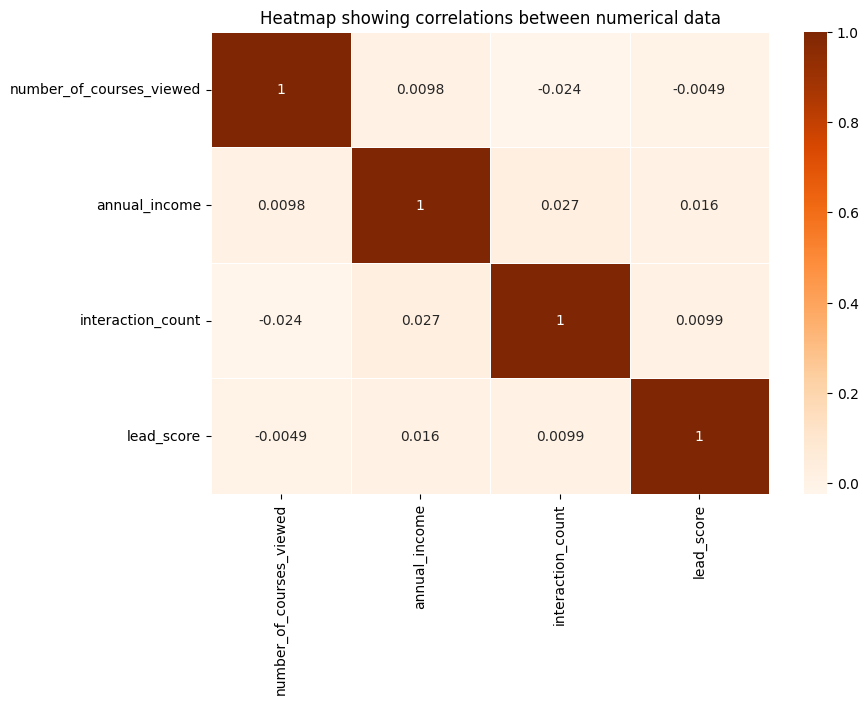

In [42]:
plt.figure(figsize=(9, 6))
sns.heatmap(df[numerical].corr(),annot=True,linewidths=.5, cmap="Oranges")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

### Question 3 

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)


df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)

In [16]:
y_train = df_train.converted.values
y_test = df_test.converted.values
y_val = df_val.converted.values

In [17]:
del df_train['converted']
del df_test['converted']
del df_val['converted']

In [18]:
len(df_train), len(df_test), len(df_val)

(876, 293, 293)

In [19]:
def mutual_info_score_converted(df):
    for category in categorical:
        score=mutual_info_score(df[category], df.converted)
        print(f'Mutual Info Score between {category} and converted: {score}')

In [20]:
mutual_info_score_converted(df_full_train)

Mutual Info Score between lead_source and converted: 0.025665373935054955
Mutual Info Score between industry and converted: 0.011684562750165564
Mutual Info Score between employment_status and converted: 0.013258496589914293
Mutual Info Score between location and converted: 0.0022530354195563346


### Question 4

In [21]:
from sklearn.metrics import accuracy_score

In [22]:
categorical, numerical

(['lead_source', 'industry', 'employment_status', 'location'],
 ['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'])

In [23]:
# Ensure target variables are integers
y_train = y_train.astype(int)
y_val   = y_val.astype(int)

# Convert DataFrame to dicts for DictVectorizer
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts   = df_val[categorical + numerical].to_dict(orient='records')

# Fit DictVectorizer
dv_new = DictVectorizer(sparse=False)
X_train = dv_new.fit_transform(train_dicts)
X_val   = dv_new.transform(val_dicts)

# Train Logistic Regression
model_new = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model_new.fit(X_train, y_train)

# Predict class labels directly
y_pred = model_new.predict(X_val)

# Compute accuracy
accuracy = (y_val == y_pred).mean()
print("Accuracy:", round(accuracy, 2))


Accuracy: 0.7


In [24]:
y_train = y_train.astype(int)
y_val   = y_val.astype(int)

In [25]:
y_pred = model_new.predict(X_val)

In [26]:
converted_pred = (y_pred >= 0.5).astype(int)

In [27]:
(y_val == converted_pred).mean()

np.float64(0.6996587030716723)

In [28]:
original_score = accuracy_score(y_val, converted_pred)
original_score

0.6996587030716723

In [29]:
y_pred = (model_new.predict_proba(X_val)[:, 1] >= 0.5).astype(int)
accuracy_score(y_val, y_pred)

0.6996587030716723

### Question 5 

- `'industry'`
- `'employment_status'`
- `'lead_score'`

In [30]:
from sklearn.metrics import accuracy_score

def feature_elimination(categorical, numerical, eliminated_feature):
    df_train_fe = df_train.copy()
    df_val_fe   = df_val.copy()

    df_train_fe = df_train_fe.drop(eliminated_feature, axis=1)
    df_val_fe   = df_val_fe.drop(eliminated_feature, axis=1)

    # update column lists
    categorical_fe = [c for c in categorical if c != eliminated_feature]
    numerical_fe   = [n for n in numerical if n != eliminated_feature]

    train_dicts_fe = df_train_fe[categorical_fe + numerical_fe].to_dict(orient='records')
    val_dicts_fe   = df_val_fe[categorical_fe + numerical_fe].to_dict(orient='records')

    dv_fe = DictVectorizer(sparse=False)
    X_train_fe = dv_fe.fit_transform(train_dicts_fe)
    X_val_fe   = dv_fe.transform(val_dicts_fe)

    model_fe = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model_fe.fit(X_train_fe, y_train.astype(int))  # ensure numeric

    y_pred_fe = model_fe.predict(X_val_fe)
    score_fe = accuracy_score(y_val.astype(int), y_pred_fe)  # ensure numeric

    print(f"Accuracy after eliminating {eliminated_feature}: {score_fe:.4f}")
    print(f"Difference vs Original: {original_score - score_fe:.4f}\n")


In [31]:
for eliminated_feature in ['lead_source', 'industry', 'employment_status']:
    feature_elimination(categorical, numerical, eliminated_feature)

Accuracy after eliminating lead_source: 0.7031
Difference vs Original: -0.0034

Accuracy after eliminating industry: 0.6997
Difference vs Original: 0.0000

Accuracy after eliminating employment_status: 0.6962
Difference vs Original: 0.0034



### Question 6

In [34]:
def check_best_c(c):
    
    # Convert DataFrame to dicts for DictVectorizer
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    val_dicts   = df_val[categorical + numerical].to_dict(orient='records')
    
    # Fit DictVectorizer
    dv_new = DictVectorizer(sparse=False)
    X_train = dv_new.fit_transform(train_dicts)
    X_val   = dv_new.transform(val_dicts)
    
    # Train Logistic Regression
    model_new = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    model_new.fit(X_train, y_train)
    
    # Predict class labels directly
    y_pred = model_new.predict(X_val)
    
    # Compute accuracy
    accuracy = (y_val == y_pred).mean()
    print(f"C : {c}, Accuracy:", round(accuracy, 2))


for c in [0.01, 0.1, 1, 10, 100]:
    check_best_c(c)

C : 0.01, Accuracy: 0.7
C : 0.1, Accuracy: 0.7
C : 1, Accuracy: 0.7
C : 10, Accuracy: 0.7
C : 100, Accuracy: 0.7
